Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data


### Importing all the important libraries

In [4]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

Connecting google drive for the data source


In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [8]:
# Defining the path for train and test images, picking these from google drive
data_dir_train = pathlib.Path("/content/gdrive/MyDrive//Melanoma-Detection-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive//Melanoma-Detection-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2246
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

As defined in the problem statement, using below parameters for the loader:
1. batch_size = 32
2. Image size = 180*180

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2246 files belonging to 9 classes.
Using 1797 files for training.


In [ ]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2246 files belonging to 9 classes.
Using 449 files for validation.


In [24]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

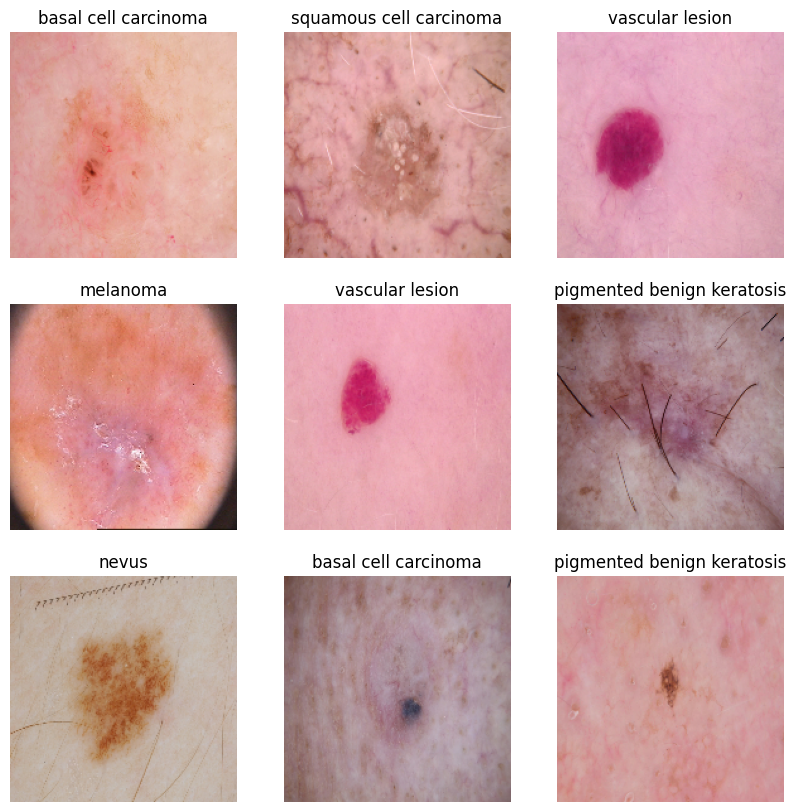

In [ ]:
import matplotlib.pyplot as plt

### Using train data to visualise, but once can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they are loaded off disk during the first epoch.
`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the first model
#### Creating a CNN model, which can attempt to accurately detect 9 classes present in the dataset.
#### Also using ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
output_classes = 9

model1 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(output_classes)
])



### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model1.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

### Train the model

In [ ]:
epochs = 20
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 392s 3s/step - loss: 2.0448 - accuracy: 0.1987 - val_loss: 2.0184 - val_accuracy: 0.1849
Epoch 2/20
57/57 [==============================] - 120s 2s/step - loss: 2.0159 - accuracy: 0.2293 - val_loss: 2.0031 - val_accuracy: 0.3430
Epoch 3/20
57/57 [==============================] - 119s 2s/step - loss: 1.9919 - accuracy: 0.2615 - val_loss: 1.9852 - val_accuracy: 0.2717
Epoch 4/20
57/57 [==============================] - 127s 2s/step - loss: 1.9662 - accuracy: 0.2827 - val_loss: 1.9358 - val_accuracy: 0.2739
Epoch 5/20
57/57 [==============================] - 122s 2s/step - loss: 1.9381 - accuracy: 0.2666 - val_loss: 1.8872 - val_accuracy: 0.3096
Epoch 6/20
57/57 [==============================] - 125s 2s/step - loss: 1.9129 - accuracy: 0.2927 - val_loss: 1.8826 - val_accuracy: 0.2851
Epoch 7/20
57/57 [==============================] - 127s 2s/step - loss: 1.8701 - accuracy: 0.3333 - val_loss: 1.7892 - val_accuracy: 0.3296
Epoch 8/20
57

### Visualizing training results

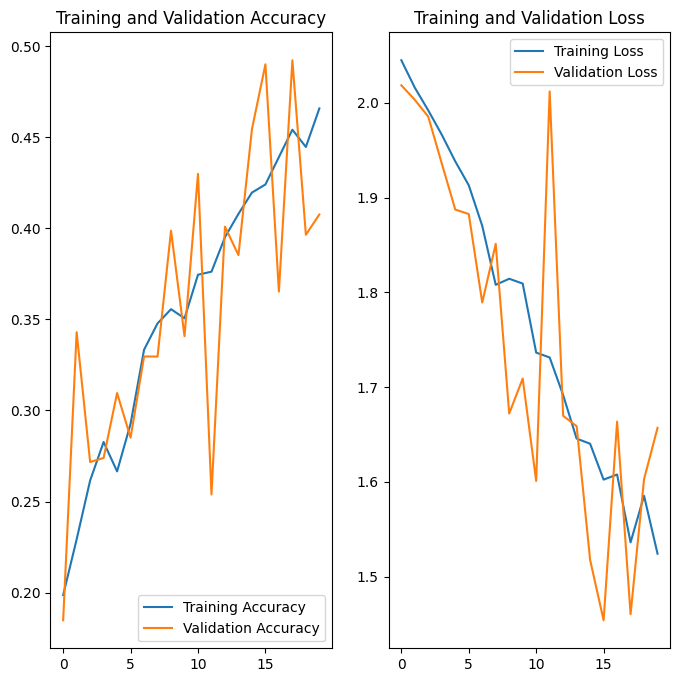

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model1 Findings : The model does not seem to perform very well depicting a very low accuracy of 0.40.

#### The model is `underfitting` as it is unable to recognise underlying patterns in the data leading to low training & validation accuracy.
1. Training accuracy is going up after every epoch & validation accurancy is also going up with that
2. Training & validation Loss are decreasing after every epoch
However, the accuracy is way below desired.

We can further optimise the model by using techniques such as dropouts, batch normalisation, data augmentation, etc


To begin with, let us do data augmentation as relevant augmentation strategies like rotation/zooming can enhance the model accuracy

In [ ]:
# Lets choose an appropriate data augumentation strategy.
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

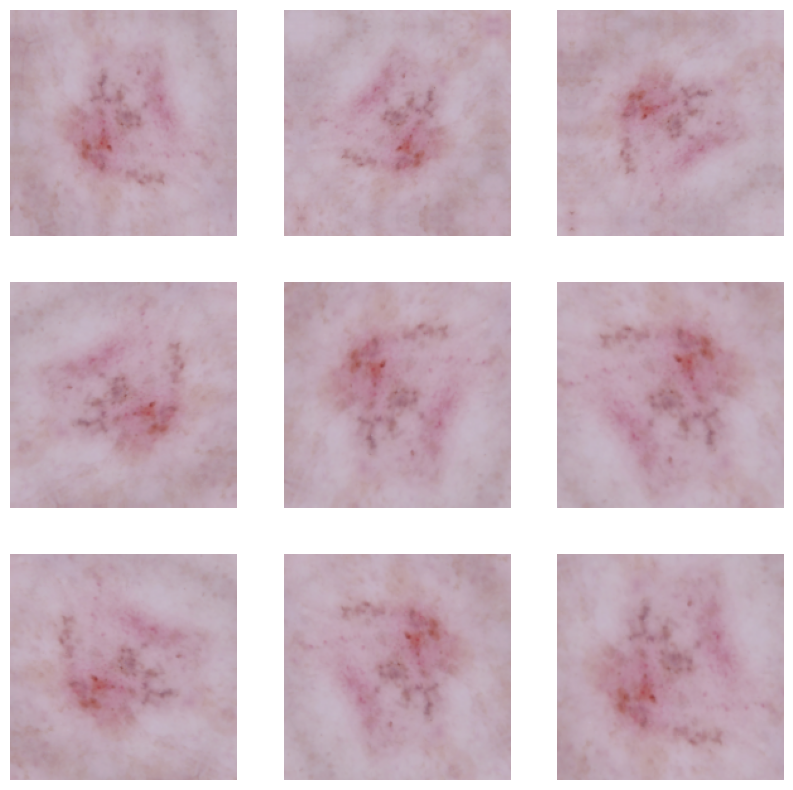

In [ ]:
# Lets visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create the second model

Along with augmented data, we will use dropouts layer to further enahnce the model this time

In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
output_classes=9
model2 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(output_classes)
])

model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 45, 45, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 45, 45, 128)      

### Compiling the model

In [ ]:
model2.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [ ]:
## Training your model for 20 epochs
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
57/57 [==============================] - 126s 2s/step - loss: 2.0587 - accuracy: 0.1920 - val_loss: 2.0258 - val_accuracy: 0.1893
Epoch 2/20
57/57 [==============================] - 123s 2s/step - loss: 2.0242 - accuracy: 0.2282 - val_loss: 2.0036 - val_accuracy: 0.2895
Epoch 3/20
57/57 [==============================] - 123s 2s/step - loss: 2.0099 - accuracy: 0.2371 - val_loss: 1.9875 - val_accuracy: 0.2918
Epoch 4/20
57/57 [==============================] - 124s 2s/step - loss: 1.9902 - accuracy: 0.2554 - val_loss: 1.9440 - val_accuracy: 0.2918
Epoch 5/20
57/57 [==============================] - 124s 2s/step - loss: 1.9698 - accuracy: 0.2710 - val_loss: 1.8891 - val_accuracy: 0.3430
Epoch 6/20
57/57 [==============================] - 122s 2s/step - loss: 1.9227 - accuracy: 0.2905 - val_loss: 1.8564 - val_accuracy: 0.3207
Epoch 7/20
57/57 [==============================] - 118s 2s/step - loss: 1.9099 - accuracy: 0.2944 - val_loss: 1.8392 - val_accuracy: 0.3073
Epoch 8/20
57

### Visualizing the results

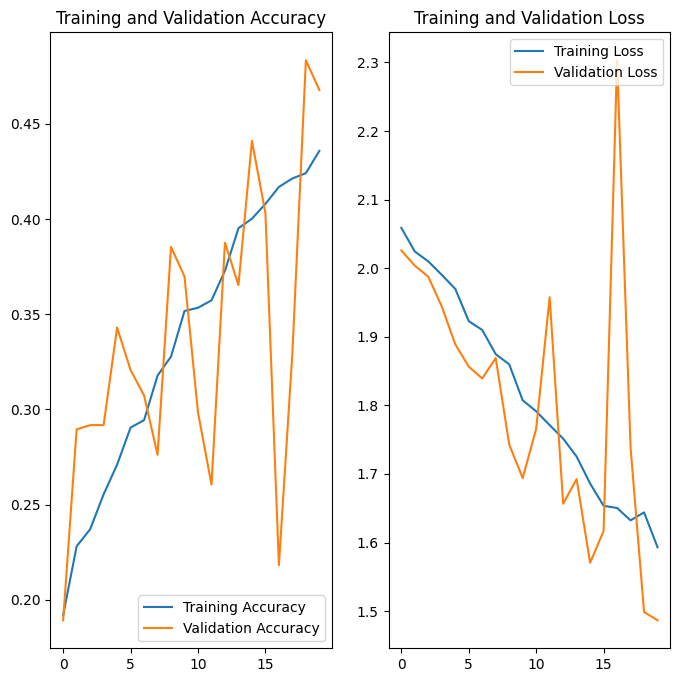

In [ ]:
epochs=20
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model2 Findings -
The model 2 does not show any noticeable improvement over model 1 performance. It is still `underfitting`.

This indicates that data augmentation did not help much in this case and we would need to analyse the data further to identify distribution of data across different classes to eliminate any major imbalance

#### Finding the distribution of classes in the training dataset.
###### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
#Checking the distribution of number of images in each class for train data set
rootPath = data_dir_train
numImages= []
for path in pathlib.Path(rootPath).iterdir():
  if path.is_dir():
    numImages.append(len([name for name in os.listdir(path)
                          if os.path.isfile(os.path.join(path, name))]))

#name of the classes
sub_directory = [name for name in os.listdir(rootPath)
                    if os.path.isdir(os.path.join(rootPath, name))]

#return dataframe with image count and class.
df = pd.DataFrame(list(zip(sub_directory,numImages)),columns =['Class', 'No. of Image'])
df

,Class,No. of Image
0,pigmented benign keratosis,469
1,nevus,357
2,basal cell carcinoma,376
3,melanoma,438
4,seborrheic keratosis,77
5,vascular lesion,139
6,squamous cell carcinoma,181
7,actinic keratosis,114
8,dermatofibroma,95


In [9]:
## Creating dataframe for the dataset.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2246

In [10]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df.head()

,Path,Label
0,/content/gdrive/MyDrive/Melanoma-Detection-Ass...,melanoma
1,/content/gdrive/MyDrive/Melanoma-Detection-Ass...,melanoma
2,/content/gdrive/MyDrive/Melanoma-Detection-Ass...,melanoma
3,/content/gdrive/MyDrive/Melanoma-Detection-Ass...,melanoma
4,/content/gdrive/MyDrive/Melanoma-Detection-Ass...,melanoma


In [ ]:
original_df['Label'].value_counts()

Label
pigmented benign keratosis    469
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64

#### Findings
##### - 'seborrheic keratosis' class has the least number of samples only 77
##### - 'pigmented benign keratosis' & 'melanoma' classes dominate the data in terms proportionate number of samples of >400

We can see there is a huge imabalance and that can make it difficult for the model to find underlying data patterns and making it more biased towards classes with higher number of samples


#### Lets rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="/content/gdrive/MyDrive//Melanoma-Detection-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive//Melanoma-Detection-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7918AD74ADA0>: 100%|██████████| 500/500 [00:28<00:00, 17.41 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive//Melanoma-Detection-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7918AD79F700>: 100%|██████████| 500/500 [00:28<00:00, 17.63 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive//Melanoma-Detection-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7918AD7CEA40>: 100%|██████████| 500/500 [00:20<00:00, 23.96 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive//Melanoma-Detection-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7918AD7E7DF0>: 100%|██████████| 500/500 [01:33<00:00,  5.33 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive//Melanoma-Detection-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2048x1536 at 0x7918AD7F6DD0>: 100%|██████████| 500/500 [01:25<00:00,  5.85 Samples/s]


Initialised with 469 image(s) found.
Output directory set to /content/gdrive/MyDrive//Melanoma-Detection-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7918ADA77010>: 100%|██████████| 500/500 [00:21<00:00, 23.54 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive//Melanoma-Detection-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7918ADB634C0>: 100%|██████████| 500/500 [00:47<00:00, 10.61 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive//Melanoma-Detection-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7918AD8D5660>: 100%|██████████| 500/500 [00:20<00:00, 23.94 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive//Melanoma-Detection-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7918AD8F3C70>: 100%|██████████| 500/500 [00:23<00:00, 21.63 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [11]:
from glob import glob

path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [12]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#lesion_list_new

In [13]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [14]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df2['Label'].value_counts()

Label
melanoma                      500
nevus                         500
seborrheic keratosis          500
vascular lesion               500
basal cell carcinoma          500
squamous cell carcinoma       500
pigmented benign keratosis    500
actinic keratosis             500
dermatofibroma                500
Name: count, dtype: int64

In [15]:
new_df= pd.concat([original_df, df2], ignore_index=True)
new_df['Label'].value_counts()

Label
pigmented benign keratosis    969
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.


Lets update the train & validation data sets to also include the newly generated images

In [16]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [17]:
data_dir_train = "/content/gdrive/MyDrive//Melanoma Detection Assignment Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [18]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Create Third Model
Along with expanded data set, we will also attemp to use batch normalization and see if that improves the performance

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Compile your model

In [ ]:
# PAYAL - Trying out new model with proper batch normalisation
#CNN Model Architecture
#Sequential allows you to create models layer-by-layer
model3 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(output_classes,activation='softmax')
])

model3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_9 (Bat  (None, 180, 180, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 batch_normalization_10 (Ba  (None, 90, 90, 64)       

In [ ]:
## Compile the Model
model3.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model3.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

# Stop training when a monitored metric has stopped improving. This will help us save unnecessary computation and time
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [ ]:
epochs = 30
## Using 30 epochs this time combined with earlyStop
history = model3.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - ETA: 0s - loss: 1.9694 - accuracy: 0.3578
Epoch 1: val_accuracy improved from -inf to 0.11507, saving model to model3.h5
169/169 [==============================] - 620s 4s/step - loss: 1.9694 - accuracy: 0.3578 - val_loss: 12.3407 - val_accuracy: 0.1151


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/30
169/169 [==============================] - ETA: 0s - loss: 1.3657 - accuracy: 0.4841
Epoch 2: val_accuracy improved from 0.11507 to 0.23682, saving model to model3.h5
169/169 [==============================] - 472s 3s/step - loss: 1.3657 - accuracy: 0.4841 - val_loss: 6.0505 - val_accuracy: 0.2368
Epoch 3/30
169/169 [==============================] - ETA: 0s - loss: 1.1794 - accuracy: 0.5595
Epoch 3: val_accuracy improved from 0.23682 to 0.53601, saving model to model3.h5
169/169 [==============================] - 466s 3s/step - loss: 1.1794 - accuracy: 0.5595 - val_loss: 1.4041 - val_accuracy: 0.5360
Epoch 4/30
169/169 [==============================] - ETA: 0s - loss: 0.9671 - accuracy: 0.6358
Epoch 4: val_accuracy did not improve from 0.53601
169/169 [==============================] - 482s 3s/step - loss: 0.9671 - accuracy: 0.6358 - val_loss: 1.3853 - val_accuracy: 0.4937
Epoch 5/30
169/169 [==============================] - ETA: 0s - loss: 0.8270 - accuracy: 0.6803
Epoch

### Model 3 Findings
The model is clearly `overfitting` as
1. Training Accuracy and Loss are coming down with every epoch
2. Test Accuracy started dropping after 14 epochs and loss also demonstrated an upward trend

This also led to early stopping of the model.

Lets remove Batch Normalisation and try the model again

### Creating Model 4

In [19]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [25]:
#Sequential allows you to create model layer-by-layer
model4 = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)),
    layers.Conv2D(32,kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Conv2D(128,kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(len(class_names),activation='softmax')
])

model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 41, 41, 128)       7

In [26]:
# Compile the model
model4.compile(optimizer="Adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model4.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [ ]:
# Train the model on 30 epochs combined with early stop
epochs = 30
history = model4.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - ETA: 0s - loss: 1.8918 - accuracy: 0.2776
Epoch 1: val_accuracy improved from -inf to 0.41425, saving model to model5.h5
169/169 [==============================] - 13s 61ms/step - loss: 1.8918 - accuracy: 0.2776 - val_loss: 1.4929 - val_accuracy: 0.4143


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/30
169/169 [==============================] - ETA: 0s - loss: 1.4917 - accuracy: 0.4330
Epoch 2: val_accuracy improved from 0.41425 to 0.52339, saving model to model5.h5
169/169 [==============================] - 10s 56ms/step - loss: 1.4917 - accuracy: 0.4330 - val_loss: 1.3367 - val_accuracy: 0.5234
Epoch 3/30
169/169 [==============================] - ETA: 0s - loss: 1.3463 - accuracy: 0.4937
Epoch 3: val_accuracy improved from 0.52339 to 0.52413, saving model to model5.h5
169/169 [==============================] - 9s 56ms/step - loss: 1.3463 - accuracy: 0.4937 - val_loss: 1.2551 - val_accuracy: 0.5241
Epoch 4/30
169/169 [==============================] - ETA: 0s - loss: 1.2457 - accuracy: 0.5367
Epoch 4: val_accuracy improved from 0.52413 to 0.55457, saving model to model5.h5
169/169 [==============================] - 10s 57ms/step - loss: 1.2457 - accuracy: 0.5367 - val_loss: 1.2045 - val_accuracy: 0.5546
Epoch 5/30
169/169 [==============================] - ETA: 0s - loss

### Model4 Findings

The model seems to be a good one depicting -
1. High Accurancy on both Training (0.91) & Validation Dataset (0.83)
2. Gradual reduction in loss on both Training & Test Datasets

Lets Visualize the model results below

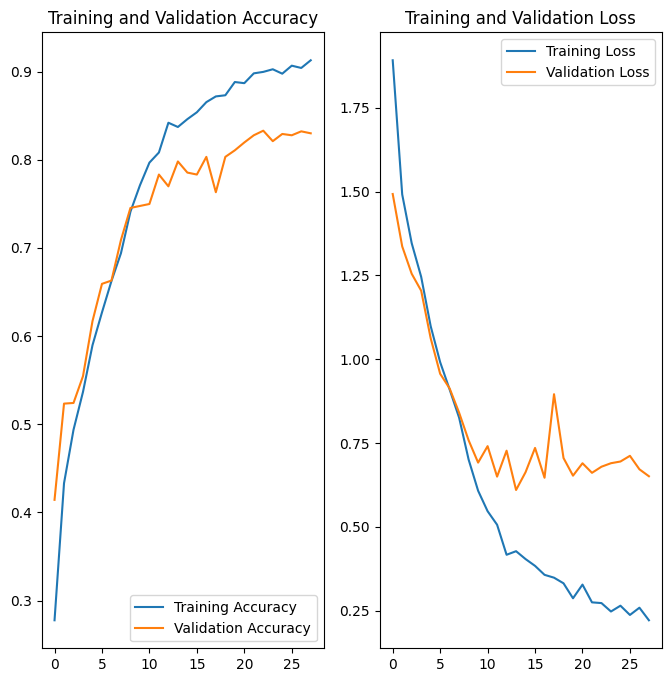

In [ ]:
actual_num_of_epochs_run= 28 #Model early stopped at 18 epocs after validation accurancy stopped improving further
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(actual_num_of_epochs_run)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Let us `try the model on test data` and pick one image to see if our model is able to predict the class correctly

PS - Though, below code shows one image being tested, this activity was done multiple times to verify the model is consistently predicting correctly


1/1 [==============================] - 0s 18ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


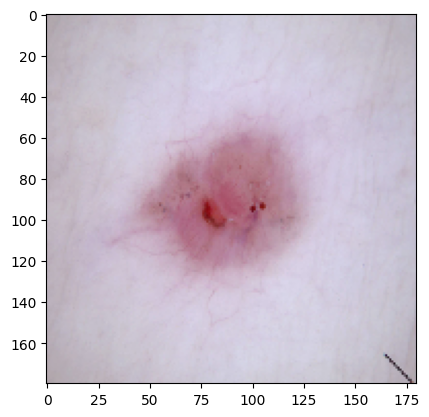

In [ ]:
from glob import glob
from tensorflow.keras.preprocessing.image import load_img

Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model4.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )


### Conclusion

1. `Model 4` is the final model depicting high Accurancy on both Training (0.91) & Validation Dataset (0.83)
2. Data Augmentation stragegy is helpful but in this case class imabalance was the main problem to deal with as some classes had much more data as compared to others
3. Dropouts layer helped avoid overfitting, overall producing a very good model